## Installation and Setup

In [1]:
!nvidia-smi

Sun Dec  7 12:33:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.83                 Driver Version: 576.83         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P0             14W /  115W |       0MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [31]:
import numpy as np
import torch
import cv2 as cv
import matplotlib.pyplot as plt
import time

# Check GPU availability
torch.cuda.is_available()

True

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load and Visualize Textures

In [26]:
def read_texture(path: str):
    texture = cv.imread(path)
    texture = cv.cvtColor(texture, cv.COLOR_BGR2RGB)

    target_size = 256
    texture = cv.resize(texture, (target_size, target_size), interpolation=cv.INTER_AREA)

    return texture

In [27]:
# Load 256x256 textures
dirt_texture = read_texture("assets/dirt.png")
stone_texture = read_texture("assets/stone.png")
diamond_texture = read_texture("assets/diamond.png")
marble_1_texture = read_texture("assets/marble_1.png")
marble_2_texture = read_texture("assets/marble_2.png")
brick_texture = read_texture("assets/brick.png")


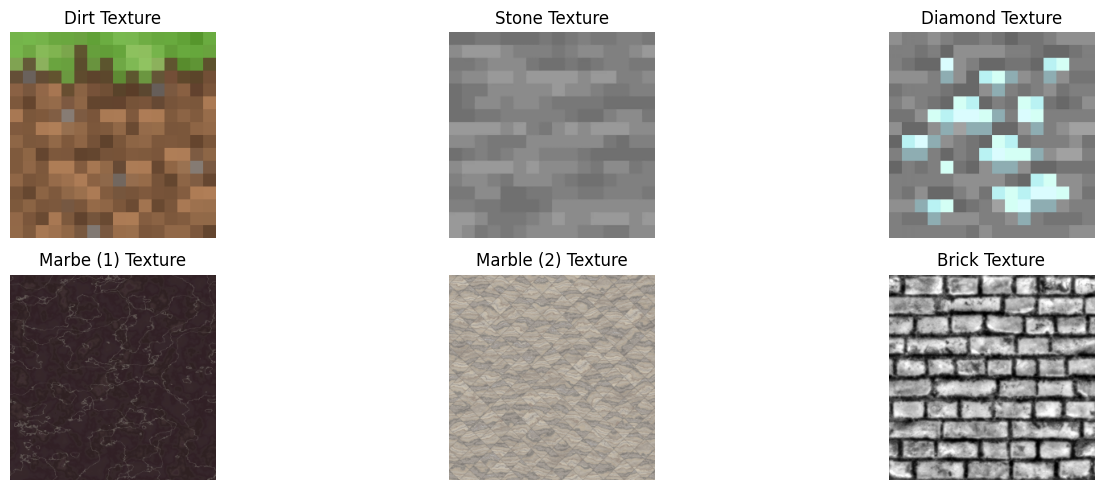

In [28]:
plt.figure(figsize=(15, 5))

plt.subplot(2, 3, 1)
plt.imshow(dirt_texture)
plt.axis('off')
plt.title(f"Dirt Texture")

plt.subplot(2, 3, 2)
plt.imshow(stone_texture)
plt.axis('off')
plt.title(f"Stone Texture")

plt.subplot(2, 3, 3)
plt.imshow(diamond_texture)
plt.axis('off')
plt.title(f"Diamond Texture")

plt.subplot(2, 3, 4)
plt.imshow(marble_1_texture)
plt.axis('off')
plt.title(f"Marbe (1) Texture")

plt.subplot(2, 3, 5)
plt.imshow(marble_2_texture)
plt.axis('off')
plt.title(f"Marble (2) Texture")

plt.subplot(2, 3, 6)
plt.imshow(brick_texture)
plt.axis('off')
plt.title(f"Brick Texture")

plt.tight_layout()
plt.show()

# Wasserstein Distance

## Sliced Quadratic Wasserstein Distance

In [46]:
def sliced_wasserstein_2_gpu(X: torch.Tensor, Y: torch.Tensor, K: int = 64) -> float:
    n, d = X.shape
    
    if not isinstance(X, torch.Tensor):
        X = torch.from_numpy(X).to(device)
    if not isinstance(Y, torch.Tensor):
        Y = torch.from_numpy(Y).to(device)
    
    X = X.float()
    Y = Y.float()

    V = torch.randn(K, d, device=device, dtype=torch.float32)
    norms = torch.linalg.norm(V, dim=1, keepdim=True)
    V = V / (norms + 1e-10)
    
    X_proj = X @ V.T  
    Y_proj = Y @ V.T  
    
    X_proj = torch.sort(X_proj, dim=0).values
    Y_proj = torch.sort(Y_proj, dim=0).values
    
    w_2 = torch.mean((X_proj - Y_proj) ** 2)
    
    return float(w_2)

## Sliced Quadratic Wasserstein Barycenter

In [47]:
def sliced_wasserstein_2_barycenter_gpu(Y_list: list[torch.Tensor], 
                                        rhos: torch.Tensor, 
                                        K: int = 32, 
                                        step_size: float = 1.0, 
                                        n_iter: int = 100) -> torch.Tensor:
    J = len(Y_list)
    n, d = Y_list[0].shape
    
    # Ensure all on GPU
    Y_list = [y.to(device).float() if not y.is_cuda else y.float() for y in Y_list]
    rhos = rhos.to(device).float() if not rhos.is_cuda else rhos.float()
    
    # Initialize with random sample from first distribution
    idx = np.random.randint(0, n)
    X = Y_list[0][idx:idx+1].repeat(n, 1)
    
    for _ in range(n_iter):
        gradient = torch.zeros((n, d), dtype=torch.float32, device=device)
        H = torch.zeros((d, d), dtype=torch.float32, device=device)
        
        V = torch.randn(K, d, device=device, dtype=torch.float32)
        norms = torch.linalg.norm(V, dim=1, keepdim=True)
        mask = norms.squeeze() > 0
        V = V[mask]
        V = V / torch.linalg.norm(V, dim=1, keepdim=True)
        K_actual = len(V)
        
        if K_actual == 0:
            continue
        
        for k in range(K_actual):
            theta = V[k]
            
            X_proj = X @ theta
            sort_idx = torch.argsort(X_proj)
            X_proj_sorted = X_proj[sort_idx]
            
            diff_sorted = torch.zeros(n, dtype=torch.float32, device=device)
            for j in range(J):
                Y_proj_j = torch.sort(Y_list[j] @ theta).values
                diff_sorted += rhos[j] * (X_proj_sorted - Y_proj_j)
            
            diff = torch.zeros(n, dtype=torch.float32, device=device)
            diff[sort_idx] = diff_sorted
            
            gradient += torch.outer(diff, theta)
            H += torch.outer(theta, theta)
        
        gradient /= K_actual
        H /= K_actual
        
        H_pinv = torch.linalg.pinv(H)
        X -= step_size * (gradient @ H_pinv)
    
    return X

## Sliced Quadratic Wasserstein Projection

In [48]:
def sliced_wasserstein_2_projection_gpu(X: torch.Tensor,
                                        Y: torch.Tensor,
                                        K: int = 32,
                                        step_size: float = 1.0,
                                        n_iter: int = 100) -> torch.Tensor:
    n, d = X.shape
    X = X.clone()
    
    # Ensure on GPU
    X = X.to(device).float()
    Y = Y.to(device).float()
    
    for _ in range(n_iter):
        gradient = torch.zeros((n, d), dtype=torch.float32, device=device)
        H = torch.zeros((d, d), dtype=torch.float32, device=device)
        
        V = torch.randn(K, d, device=device, dtype=torch.float32)
        norms = torch.linalg.norm(V, dim=1, keepdim=True)
        mask = (norms.squeeze() > 1e-10)
        V = V[mask]
        if len(V) == 0:
            continue
        V = V / torch.linalg.norm(V, dim=1, keepdim=True)
        K_actual = len(V)
        
        for k in range(K_actual):
            theta = V[k]
            
            X_proj = X @ theta
            sort_idx = torch.argsort(X_proj)
            X_proj_sorted = X_proj[sort_idx]
            
            Y_proj = torch.sort(Y @ theta).values
            diff_sorted = X_proj_sorted - Y_proj
            
            diff = torch.zeros(n, dtype=torch.float32, device=device)
            diff[sort_idx] = diff_sorted
            
            gradient += torch.outer(diff, theta)
            H += torch.outer(theta, theta)
        
        gradient /= K_actual
        H /= K_actual
        
        H_pinv = torch.linalg.pinv(H)
        X -= step_size * (gradient @ H_pinv)
    
    return X

## Test Functions

In [49]:
# Test sliced Wasserstein distance
X_test = torch.tensor([[0], [0.5], [1]], dtype=torch.float32, device=device)
Y_test = torch.tensor([[1], [1.5], [2]], dtype=torch.float32, device=device)

dist = sliced_wasserstein_2_gpu(X_test, Y_test, K=100)
print(f"Wasserstein distance: {dist:.4f} (expected: ~1.0)")

# Test barycenter
Y1 = torch.tensor([[0], [1], [2]], dtype=torch.float32, device=device)
Y2 = torch.tensor([[1], [1], [1]], dtype=torch.float32, device=device)
Y_list = [Y1, Y2]
rhos = torch.tensor([0.5, 0.5], dtype=torch.float32, device=device)

X_bar = sliced_wasserstein_2_barycenter_gpu(Y_list, rhos, K=16, step_size=0.5, n_iter=100)
print(f"\nBarycenter: {X_bar.cpu().numpy().ravel()}")

# Test projection
X_test2 = torch.tensor([[0], [0.5], [1]], dtype=torch.float32, device=device)
Y_test2 = torch.tensor([[1], [1.5], [2]], dtype=torch.float32, device=device)

X_proj = sliced_wasserstein_2_projection_gpu(X_test2, Y_test2, K=16, step_size=0.5, n_iter=100)
print(f"\nProjection: {X_proj.cpu().numpy().ravel()}")

Wasserstein distance: 1.0000 (expected: ~1.0)

Barycenter: [0.5 1.  1.5]

Barycenter: [0.5 1.  1.5]

Projection: [1.  1.5 2. ]

Projection: [1.  1.5 2. ]


# GPU-Accelerated Texture Synthesis (PyTorch)

## First Order Statistical Mixing

In [ ]:
def first_order_texture_mixing_gpu(textures: list[np.ndarray], 
                                   rhos: np.ndarray,
                                   height: int = 4,
                                   order: int = 3,
                                   n_iter: int = 6,
                                   K: int = 32,
                                   step_size: float = 0.4,
                                   barycenter_iter: int = 40,
                                   proj_iter: int = 8,
                                   verbose: bool = True) -> np.ndarray:
    J = len(textures)
    
    rhos_gpu = torch.tensor(rhos, dtype=torch.float32, device=device)
    
    # Normalize textures
    textures = [tex.astype(np.float64) / 255.0 if tex.max() > 1 else tex.astype(np.float64) 
                for tex in textures]
    
    P, Q, _ = textures[0].shape
    
    if verbose:
        print(f"Computing steerable pyramids for {J} textures of size {P}x{Q}...")
        start_time = time.time()
    
    # Build pyramids (CPU operation via pyrtools)
    pyramids = []
    for j, tex in enumerate(textures):
        pyr_channels = []
        for c in range(3):
            pyr_c = pt.pyramids.SteerablePyramidFreq(tex[:, :, c], height=height, order=order-1, is_complex=False)
            pyr_channels.append(pyr_c)
        pyramids.append(pyr_channels)
    
    pyr_keys = list(pyramids[0][0].pyr_coeffs.keys())
    
    if verbose:
        print(f"  Pyramid decomposition complete ({time.time() - start_time:.2f}s)")
        print(f"  {len(pyr_keys)} subbands")
        print("\nComputing coefficient barycenters on GPU...")
        start_time = time.time()
    
    # Compute barycenters for each subband
    Y_ell = {}
    for l_dix, key in enumerate(pyr_keys):
        Y_list_cpu = []
        for j in range(J):
            coeffs_rgb = []
            for c in range(3):
                coeff = pyramids[j][c].pyr_coeffs[key]
                coeffs_rgb.append(coeff.flatten())
            coeff_flat = np.stack(coeffs_rgb, axis=1)
            Y_list_cpu.append(coeff_flat)
        
        # Convert to torch tensors
        Y_list_gpu = [torch.from_numpy(y).float().to(device) for y in Y_list_cpu]
        
        Y_ell[key] = sliced_wasserstein_2_barycenter_gpu(
            Y_list_gpu, rhos_gpu, K=K, step_size=step_size, n_iter=barycenter_iter
        )
        
        if verbose and (l_dix + 1) % 5 == 0:
            print(f"  Processed {l_dix + 1}/{len(pyr_keys)} subbands")
    
    if verbose:
        print(f"  Coefficient barycenters complete ({time.time() - start_time:.2f}s)")
        print("\nComputing pixel barycenter on GPU...")
        start_time = time.time()
    
    # Compute pixel barycenter
    pixel_Y_list_gpu = [torch.from_numpy(tex.reshape(-1, 3)).float().to(device) for tex in textures]
    Y_pixels = sliced_wasserstein_2_barycenter_gpu(
        pixel_Y_list_gpu, rhos_gpu, K=K, step_size=step_size, n_iter=barycenter_iter
    )
    
    if verbose:
        print(f"  Pixel barycenter complete ({time.time() - start_time:.2f}s)")
        print(f"\nStarting iterative synthesis ({n_iter} iterations)...")
    
    # Initialize with white noise
    f_k = np.random.randn(P, Q, 3).astype(np.float64) * 0.2 + 0.5
    f_k = np.clip(f_k, 0, 1)
    
    # Iterative synthesis
    for k in range(n_iter):
        iter_start = time.time()
        
        # Build pyramid of current image
        pyr_k_channels = []
        for c in range(3):
            pyr_k_c = pt.pyramids.SteerablePyramidFreq(f_k[:, :, c], height=height, order=order-1, is_complex=False)
            pyr_k_channels.append(pyr_k_c)
        
        # Project coefficients
        c_k_channels = [{} for _ in range(3)]
        for key in pyr_keys:
            coeffs_rgb = []
            original_shape = None
            for c in range(3):
                coeff = pyr_k_channels[c].pyr_coeffs[key]
                if original_shape is None:
                    original_shape = coeff.shape
                coeffs_rgb.append(coeff.flatten())
            
            coeff_flat_cpu = np.stack(coeffs_rgb, axis=1)
            coeff_flat_gpu = torch.from_numpy(coeff_flat_cpu).float().to(device)
            
            coeff_proj_gpu = sliced_wasserstein_2_projection_gpu(
                coeff_flat_gpu, Y_ell[key], K=K, step_size=step_size, n_iter=proj_iter
            )
            
            coeff_proj_cpu = coeff_proj_gpu.cpu().numpy()
            for c in range(3):
                c_k_channels[c][key] = coeff_proj_cpu[:, c].reshape(original_shape)
        
        # Reconstruct image
        f_tilde_k_channels = []
        for c in range(3):
            pyr_k_channels[c].pyr_coeffs = c_k_channels[c]
            recon_c = pyr_k_channels[c].recon_pyr()
            f_tilde_k_channels.append(recon_c)
        
        f_tilde_k = np.stack(f_tilde_k_channels, axis=-1)
        
        # Project pixels
        pixels_flat_gpu = torch.from_numpy(f_tilde_k.reshape(-1, 3)).float().to(device)
        pixels_proj_gpu = sliced_wasserstein_2_projection_gpu(
            pixels_flat_gpu, Y_pixels, K=K, step_size=step_size, n_iter=proj_iter
        )
        
        pixels_proj_cpu = pixels_proj_gpu.cpu().numpy()
        f_k = pixels_proj_cpu.reshape(P, Q, 3)
        f_k = np.clip(f_k, 0, 1)
        
        if verbose:
            print(f"  Iteration {k+1}/{n_iter} complete ({time.time() - iter_start:.2f}s)")
    
    if verbose:
        print("\nSynthesis complete!")
    
    result = (f_k * 255).astype(np.uint8)
    return result

## Higher-Order Statistical Mixing

In [52]:
def extract_blocks_gpu(coeffs_rgb: list[torch.Tensor], block_size: int) -> tuple[torch.Tensor, list]:
    h, w = coeffs_rgb[0].shape
    blocks = []
    positions = []
    
    for i in range(0, h - block_size + 1):
        for j in range(0, w - block_size + 1):
            block_features = []
            for c in range(3):
                block = coeffs_rgb[c][i:i+block_size, j:j+block_size]
                block_features.append(block.flatten())
            
            block_vec = torch.cat(block_features)
            blocks.append(block_vec)
            positions.append((i, j))
    
    if len(blocks) > 0:
        blocks = torch.stack(blocks)
    else:
        blocks = torch.tensor([], dtype=torch.float32, device=device)
    
    return blocks, positions


def reconstruct_from_blocks_gpu(blocks: torch.Tensor, 
                                positions: list, 
                                shape: tuple, 
                                block_size: int) -> list[torch.Tensor]:
    h, w = shape
    coeffs_accum = [torch.zeros((h, w), dtype=torch.float32, device=device) for _ in range(3)]
    overlap_count = torch.zeros((h, w), dtype=torch.float32, device=device)
    
    block_len = block_size * block_size
    
    for idx, (i, j) in enumerate(positions):
        block_vec = blocks[idx]
        
        for c in range(3):
            block_c = block_vec[c * block_len:(c + 1) * block_len]
            block_2d = block_c.reshape(block_size, block_size)
            coeffs_accum[c][i:i+block_size, j:j+block_size] += block_2d
        
        overlap_count[i:i+block_size, j:j+block_size] += 1
    
    # Average - avoid division by zero
    coeffs_out = []
    for c in range(3):
        coeff_c = torch.zeros_like(coeffs_accum[c])
        mask = overlap_count > 0
        coeff_c[mask] = coeffs_accum[c][mask] / overlap_count[mask]
        coeffs_out.append(coeff_c)
    
    return coeffs_out

In [ ]:
def higher_order_texture_mixing_gpu(textures: list[np.ndarray], 
                                    rhos: np.ndarray,
                                    height: int = 4,
                                    order: int = 3,
                                    n_iter: int = 6,
                                    K: int = 32,
                                    step_size: float = 0.4,
                                    barycenter_iter: int = 40,
                                    proj_iter: int = 8,
                                    block_size: int = 4,
                                    verbose: bool = True) -> np.ndarray:
    J = len(textures)
    rhos_gpu = torch.tensor(rhos, dtype=torch.float32, device=device)
    
    # Normalize textures
    textures = [tex.astype(np.float64) / 255.0 if tex.max() > 1 else tex.astype(np.float64) 
                for tex in textures]
    
    P, Q, _ = textures[0].shape
    
    if verbose:
        print(f"Computing steerable pyramids for {J} textures of size {P}x{Q}...")
        start_time = time.time()
    
    # Build pyramids
    pyramids = []
    for j, tex in enumerate(textures):
        pyr_channels = []
        for c in range(3):
            pyr_c = pt.pyramids.SteerablePyramidFreq(tex[:, :, c], height=height, order=order-1, is_complex=False)
            pyr_channels.append(pyr_c)
        pyramids.append(pyr_channels)
    
    pyr_keys = list(pyramids[0][0].pyr_coeffs.keys())
    
    if verbose:
        print(f"  Pyramid decomposition complete ({time.time() - start_time:.2f}s)")
        print(f"  {len(pyr_keys)} subbands")
        print(f"\nComputing joint distribution barycenters (block_size={block_size}x{block_size}) on GPU...")
        start_time = time.time()
    
    # Compute joint distribution barycenters
    C_ell = {}
    coeff_shapes = {}
    
    for l_idx, key in enumerate(pyr_keys):
        coeff_shape = pyramids[0][0].pyr_coeffs[key].shape
        coeff_shapes[key] = coeff_shape
        h, w = coeff_shape
        
        C_list_gpu = []
        
        for j in range(J):
            # Move coefficients to GPU as torch tensors
            coeffs_rgb_gpu = []
            for c in range(3):
                coeff = pyramids[j][c].pyr_coeffs[key]
                coeffs_rgb_gpu.append(torch.from_numpy(coeff).float().to(device))
            
            blocks_gpu, _ = extract_blocks_gpu(coeffs_rgb_gpu, block_size)
            
            if len(blocks_gpu) > 0:
                C_list_gpu.append(blocks_gpu)
        
        # Compute barycenter
        if len(C_list_gpu) > 0 and len(C_list_gpu[0]) > 0:
            C_ell[key] = sliced_wasserstein_2_barycenter_gpu(
                C_list_gpu, rhos_gpu, K=K, step_size=step_size, n_iter=barycenter_iter
            )
        
        if verbose and (l_idx + 1) % 5 == 0:
            print(f"  Processed {l_dix + 1}/{len(pyr_keys)} subbands")
    
    if verbose:
        print(f"  Joint barycenters complete ({time.time() - start_time:.2f}s)")
        print("\nComputing pixel barycenter on GPU...")
        start_time = time.time()
    
    # Compute pixel barycenter
    pixel_Y_list_gpu = [torch.from_numpy(tex.reshape(-1, 3)).float().to(device) for tex in textures]
    Y_pixels = sliced_wasserstein_2_barycenter_gpu(
        pixel_Y_list_gpu, rhos_gpu, K=K, step_size=step_size, n_iter=barycenter_iter
    )
    
    if verbose:
        print(f"  Pixel barycenter complete ({time.time() - start_time:.2f}s)")
        print(f"\nStarting iterative synthesis ({n_iter} iterations)...")
    
    # Initialize with white noise
    f_k = np.random.randn(P, Q, 3).astype(np.float64) * 0.2 + 0.5
    f_k = np.clip(f_k, 0, 1)
    
    # Iterative synthesis
    for k in range(n_iter):
        iter_start = time.time()
        
        # Build pyramid
        pyr_k_channels = []
        for c in range(3):
            pyr_k_c = pt.pyramids.SteerablePyramidFreq(f_k[:, :, c], height=height, order=order-1, is_complex=False)
            pyr_k_channels.append(pyr_k_c)
        
        # Project using joint distributions
        c_k_channels = [{} for _ in range(3)]
        
        for key in pyr_keys:
            if key not in C_ell:
                # Skip if subband too small
                for c in range(3):
                    c_k_channels[c][key] = pyr_k_channels[c].pyr_coeffs[key]
                continue
            
            h, w = coeff_shapes[key]
            
            # Move current coefficients to GPU
            coeffs_k_rgb_gpu = []
            for c in range(3):
                coeff = pyr_k_channels[c].pyr_coeffs[key]
                coeffs_k_rgb_gpu.append(torch.from_numpy(coeff).float().to(device))
            
            blocks_k_gpu, block_positions = extract_blocks_gpu(coeffs_k_rgb_gpu, block_size)
            
            if len(blocks_k_gpu) == 0:
                for c in range(3):
                    c_k_channels[c][key] = pyr_k_channels[c].pyr_coeffs[key]
                continue
            
            # Project
            blocks_proj_gpu = sliced_wasserstein_2_projection_gpu(
                blocks_k_gpu, C_ell[key], K=K, step_size=step_size, n_iter=proj_iter
            )
            
            # Reconstruct
            coeffs_proj_rgb_gpu = reconstruct_from_blocks_gpu(
                blocks_proj_gpu, block_positions, (h, w), block_size
            )
            
            # Move back to CPU
            for c in range(3):
                c_k_channels[c][key] = coeffs_proj_rgb_gpu[c].cpu().numpy()
        
        # Reconstruct image
        f_tilde_k_channels = []
        for c in range(3):
            pyr_k_channels[c].pyr_coeffs = c_k_channels[c]
            recon_c = pyr_k_channels[c].recon_pyr()
            f_tilde_k_channels.append(recon_c)
        
        f_tilde_k = np.stack(f_tilde_k_channels, axis=-1)
        
        # Project pixels
        pixels_flat_gpu = torch.from_numpy(f_tilde_k.reshape(-1, 3)).float().to(device)
        pixels_proj_gpu = sliced_wasserstein_2_projection_gpu(
            pixels_flat_gpu, Y_pixels, K=K, step_size=step_size, n_iter=proj_iter
        )
        
        f_k = pixels_proj_gpu.cpu().numpy().reshape(P, Q, 3)
        f_k = np.clip(f_k, 0, 1)
        
        if verbose:
            print(f"  Iteration {k+1}/{n_iter} complete ({time.time() - iter_start:.2f}s)")
    
    if verbose:
        print("\nSynthesis complete!")
    
    result = (f_k * 255).astype(np.uint8)
    return result

# Test First-Order Mixing with 256x256 Textures

Starting first-order synthesis with GPU acceleration...
Input size: (256, 256, 3)
Computing steerable pyramids for 2 textures of size 256x256...
  Pyramid decomposition complete (0.15s)
  11 subbands

Computing coefficient barycenters on GPU...
  Processed 5/11 subbands
  Processed 5/11 subbands
  Processed 10/11 subbands
  Processed 10/11 subbands
  Coefficient barycenters complete (34.95s)

Computing pixel barycenter on GPU...
  Coefficient barycenters complete (34.95s)

Computing pixel barycenter on GPU...
  Pixel barycenter complete (3.47s)

Starting iterative synthesis (5 iterations)...
  Pixel barycenter complete (3.47s)

Starting iterative synthesis (5 iterations)...
  Iteration 1/5 complete (26.14s)
  Iteration 1/5 complete (26.14s)
  Iteration 2/5 complete (26.48s)
  Iteration 2/5 complete (26.48s)
  Iteration 3/5 complete (25.99s)
  Iteration 3/5 complete (25.99s)
  Iteration 4/5 complete (26.45s)
  Iteration 4/5 complete (26.45s)
  Iteration 5/5 complete (24.82s)

Synthesis 

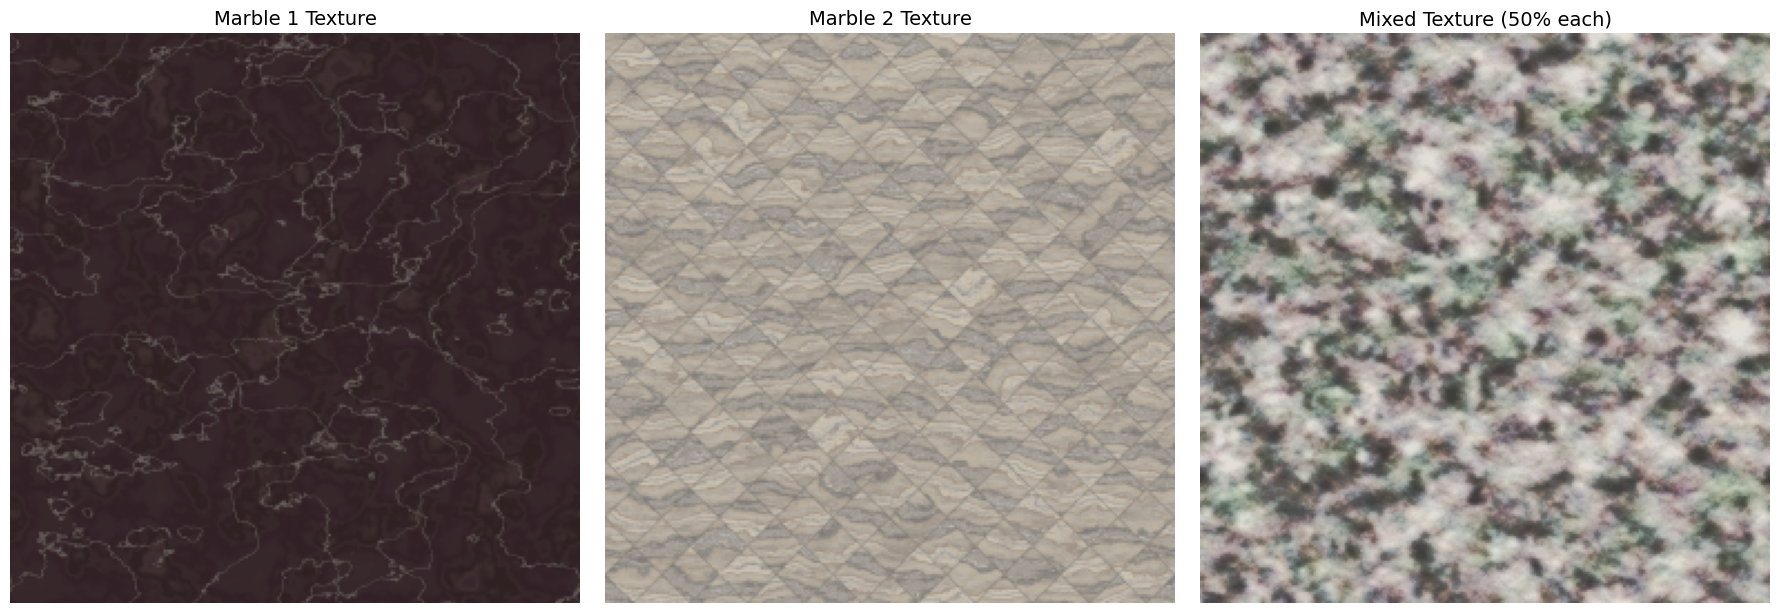

In [54]:
# Test with marble textures at 256x256
textures = [brick_texture, marble_2_texture]
rhos = np.array([0.5, 0.5])

print("Starting first-order synthesis with GPU acceleration...")
print(f"Input size: {marble_1_texture.shape}")

total_start = time.time()
synthesized = first_order_texture_mixing_gpu(
    textures, rhos,
    height=3,
    order=3,
    n_iter=5,
    K=64,
    step_size=0.1,
    barycenter_iter=50,
    proj_iter=50,
    verbose=True
)
total_time = time.time() - total_start

print(f"\n{'='*60}")
print(f"Total synthesis time: {total_time:.2f} seconds")
print(f"{'='*60}")

# Display results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(marble_1_texture)
axes[0].set_title("Marble 1 Texture", fontsize=14)
axes[0].axis('off')

axes[1].imshow(marble_2_texture)
axes[1].set_title("Marble 2 Texture", fontsize=14)
axes[1].axis('off')

axes[2].imshow(synthesized)
axes[2].set_title("Mixed Texture (50% each)", fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Generate Texture Interpolation Sequence

Generating 11 interpolated textures at 256x256...

[1/11] Synthesizing with rho = 0.0 (weights: [0.0, 1.0])
  Completed in 369.39s - Saved as synthesized_rho_0.0.png

[2/11] Synthesizing with rho = 0.1 (weights: [0.1, 0.9])
  Completed in 421.77s - Saved as synthesized_rho_0.1.png

[3/11] Synthesizing with rho = 0.2 (weights: [0.2, 0.8])
  Completed in 518.26s - Saved as synthesized_rho_0.2.png

[4/11] Synthesizing with rho = 0.3 (weights: [0.3, 0.7])
  Completed in 479.72s - Saved as synthesized_rho_0.3.png

[5/11] Synthesizing with rho = 0.4 (weights: [0.4, 0.6])
  Completed in 326.58s - Saved as synthesized_rho_0.4.png

[6/11] Synthesizing with rho = 0.5 (weights: [0.5, 0.5])
  Completed in 379.44s - Saved as synthesized_rho_0.5.png

[7/11] Synthesizing with rho = 0.6 (weights: [0.6, 0.4])
  Completed in 459.37s - Saved as synthesized_rho_0.6.png

[8/11] Synthesizing with rho = 0.7 (weights: [0.7, 0.3])
  Completed in 928.08s - Saved as synthesized_rho_0.7.png

[9/11] Synthesizing w

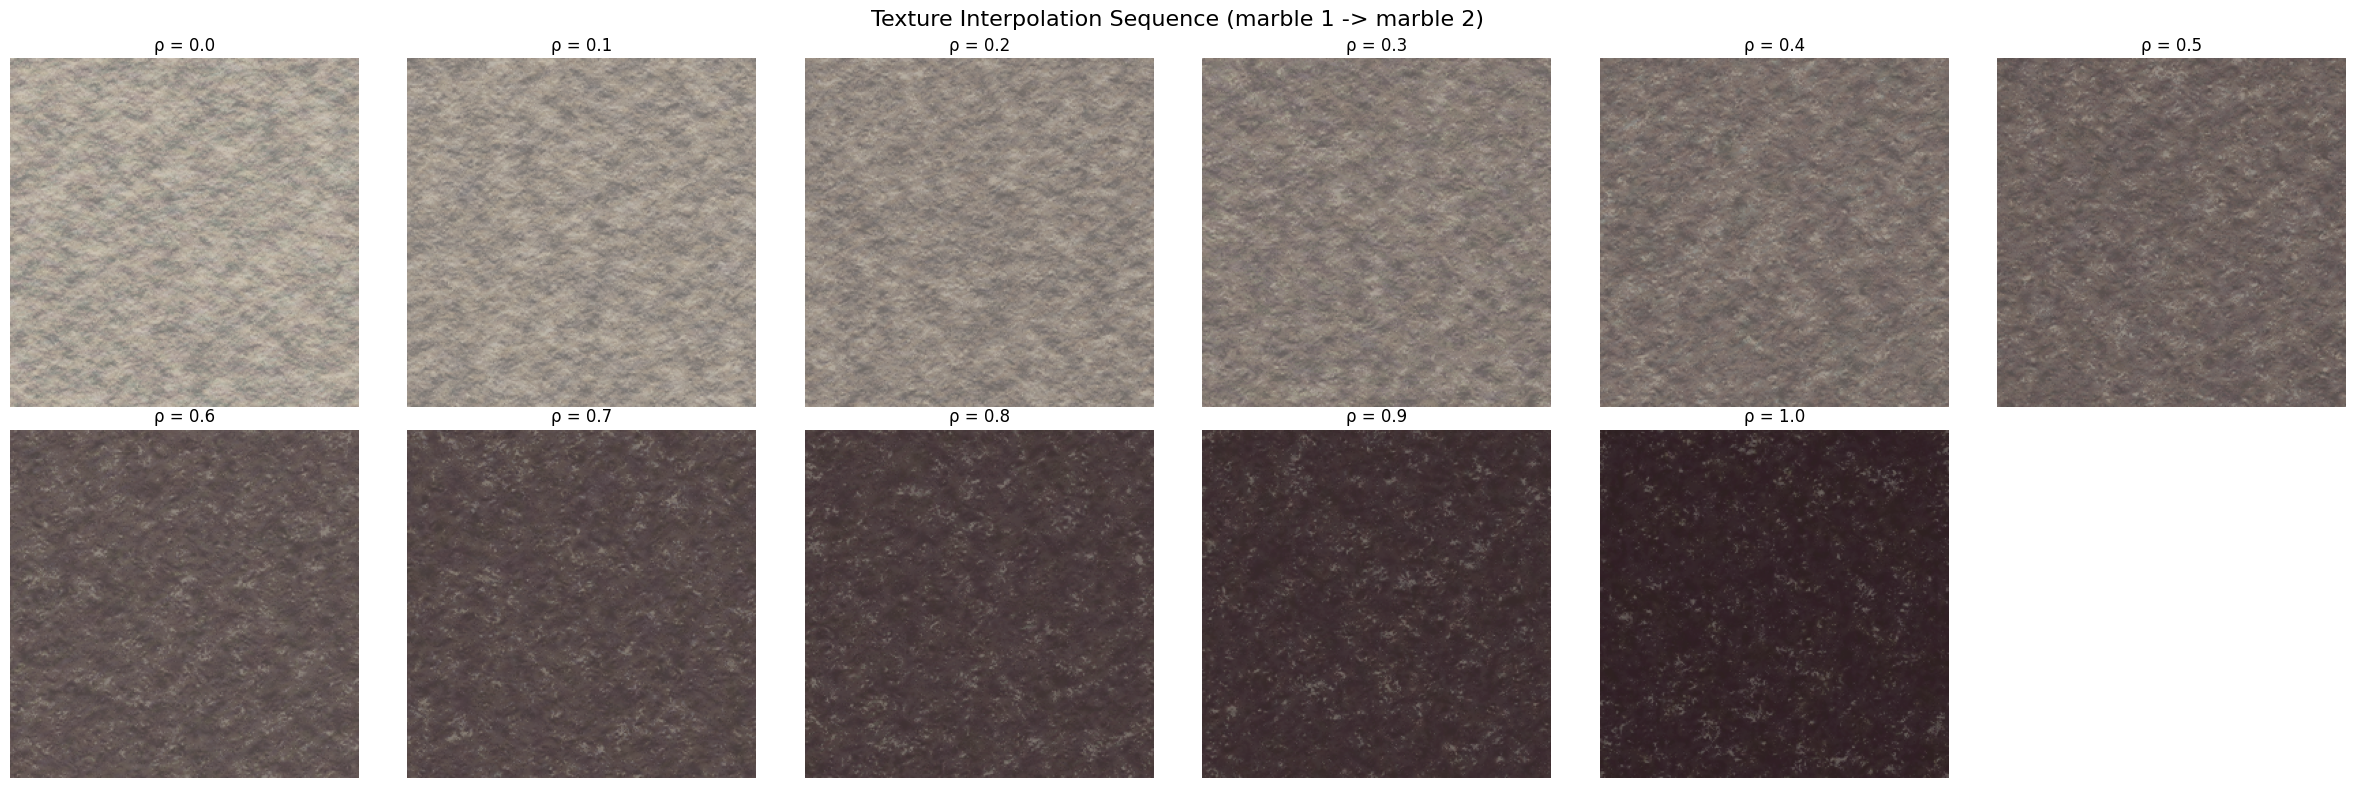

In [20]:
output_dir = "output/first_order"
os.makedirs(output_dir, exist_ok=True)

# Use marble textures for interpolation
textures = [marble_1_texture, marble_2_texture]

# Save input textures
cv.imwrite(os.path.join(output_dir, "texture_A.png"), cv.cvtColor(marble_1_texture, cv.COLOR_RGB2BGR))
cv.imwrite(os.path.join(output_dir, "texture_B.png"), cv.cvtColor(marble_2_texture, cv.COLOR_RGB2BGR))

# Generate interpolation from 0.0 to 1.0
rhos_list = np.arange(0.0, 1.1, 0.1)

print(f"Generating {len(rhos_list)} interpolated textures at 256x256...")
print("="*60)

results = []
for i, rho in enumerate(rhos_list):
    rhos = np.array([rho, 1 - rho])
    
    print(f"\n[{i+1}/{len(rhos_list)}] Synthesizing with rho = {rho:.1f} (weights: [{rho:.1f}, {1-rho:.1f}])")
    
    start = time.time()
    synthesized = first_order_texture_mixing_gpu(
        textures, rhos,
        height=3,
        order=3,
        n_iter=6,
        K=64,
        step_size=0.1,
        barycenter_iter=100,
        proj_iter=50,
        verbose=False
    )
    elapsed = time.time() - start
    
    # Save
    filename = f"synthesized_rho_{rho:.1f}.png"
    cv.imwrite(os.path.join(output_dir, filename), cv.cvtColor(synthesized, cv.COLOR_RGB2BGR))
    
    results.append(synthesized)
    print(f"  Completed in {elapsed:.2f}s - Saved as {filename}")

print(f"\n{'='*60}")
print(f"All textures saved to: {output_dir}")
print(f"{'='*60}")

# Display all results
fig, axes = plt.subplots(2, 6, figsize=(24, 8))
axes = axes.flatten()

for i, (rho, result) in enumerate(zip(rhos_list, results)):
    axes[i].imshow(result)
    axes[i].set_title(f"ρ = {rho:.1f}", fontsize=12)
    axes[i].axis('off')

# Hide extra subplots if any
for i in range(len(rhos_list), len(axes)):
    axes[i].axis('off')

plt.suptitle("Texture Interpolation Sequence (Marble 1 -> Marble 2)", fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# Test Higher-Order Mixing with 256x256 Textures

Starting higher-order synthesis with GPU acceleration...
Input size: (256, 256, 3)
Computing steerable pyramids for 2 textures of size 256x256...
  Pyramid decomposition complete (0.17s)
  11 subbands

Computing joint distribution barycenters (block_size=4x4) on GPU...


  Processed 5/11 subbands
  Processed 10/11 subbands
  Processed 10/11 subbands
  Joint barycenters complete (154.55s)

Computing pixel barycenter on GPU...
  Joint barycenters complete (154.55s)

Computing pixel barycenter on GPU...
  Pixel barycenter complete (6.99s)

Starting iterative synthesis (6 iterations)...
  Pixel barycenter complete (6.99s)

Starting iterative synthesis (6 iterations)...
  Iteration 1/6 complete (121.47s)
  Iteration 1/6 complete (121.47s)
  Iteration 2/6 complete (126.60s)
  Iteration 2/6 complete (126.60s)
  Iteration 3/6 complete (161.74s)
  Iteration 3/6 complete (161.74s)
  Iteration 4/6 complete (171.99s)
  Iteration 4/6 complete (171.99s)
  Iteration 5/6 complete (162.99s)
  Iteration 5/6 complete (162.99s)
  Iteration 6/6 complete (199.06s)

Synthesis complete!

Total synthesis time: 1105.64 seconds
  Iteration 6/6 complete (199.06s)

Synthesis complete!

Total synthesis time: 1105.64 seconds


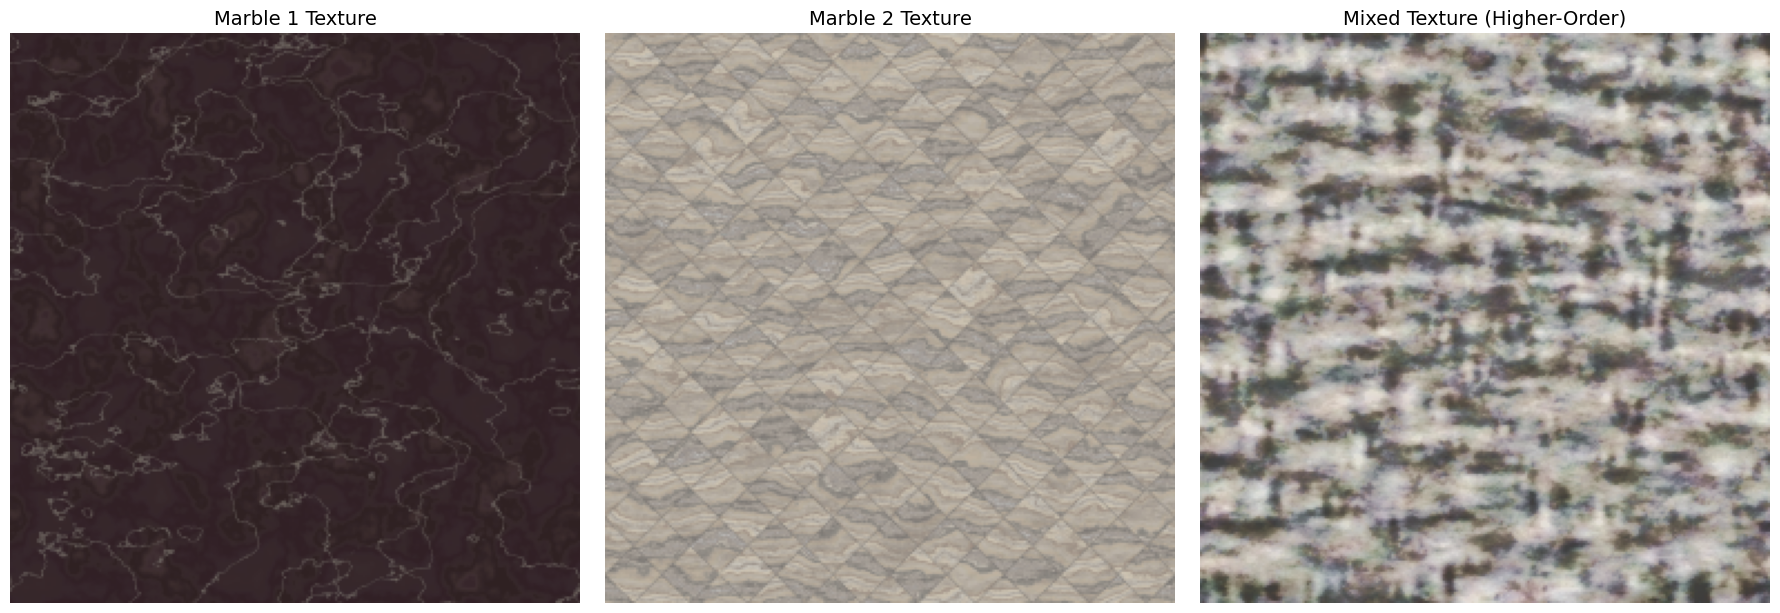

In [55]:
# Test with marble textures at 256x256
textures = [brick_texture, marble_2_texture]
rhos = np.array([0.5, 0.5])

print("Starting higher-order synthesis with GPU acceleration...")
print(f"Input size: {marble_1_texture.shape}")

total_start = time.time()
synthesized_ho = higher_order_texture_mixing_gpu(
    textures, rhos,
    height=3,
    order=3,
    n_iter=6,
    K=64,
    step_size=0.1,
    barycenter_iter=100,
    proj_iter=50,
    block_size=4,
    verbose=True
)
total_time = time.time() - total_start

print(f"\n{'='*60}")
print(f"Total synthesis time: {total_time:.2f} seconds")
print(f"{'='*60}")

# Display results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(marble_1_texture)
axes[0].set_title("Marble 1 Texture", fontsize=14)
axes[0].axis('off')

axes[1].imshow(marble_2_texture)
axes[1].set_title("Marble 2 Texture", fontsize=14)
axes[1].axis('off')

axes[2].imshow(synthesized_ho)
axes[2].set_title("Mixed Texture (Higher-Order)", fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Generate Higher-Order Texture Interpolation Sequence

Generating 11 interpolated textures with higher-order mixing at 256x256...

[1/11] Synthesizing with rho = 0.0 (weights: [0.0, 1.0])
  Completed in 1011.62s - Saved as synthesized_rho_0.0.png

[2/11] Synthesizing with rho = 0.1 (weights: [0.1, 0.9])
  Completed in 1011.62s - Saved as synthesized_rho_0.0.png

[2/11] Synthesizing with rho = 0.1 (weights: [0.1, 0.9])
  Completed in 1068.64s - Saved as synthesized_rho_0.1.png

[3/11] Synthesizing with rho = 0.2 (weights: [0.2, 0.8])
  Completed in 1068.64s - Saved as synthesized_rho_0.1.png

[3/11] Synthesizing with rho = 0.2 (weights: [0.2, 0.8])
  Completed in 1017.39s - Saved as synthesized_rho_0.2.png

[4/11] Synthesizing with rho = 0.3 (weights: [0.3, 0.7])
  Completed in 1017.39s - Saved as synthesized_rho_0.2.png

[4/11] Synthesizing with rho = 0.3 (weights: [0.3, 0.7])
  Completed in 1502.06s - Saved as synthesized_rho_0.3.png

[5/11] Synthesizing with rho = 0.4 (weights: [0.4, 0.6])
  Completed in 1502.06s - Saved as synthesized_r

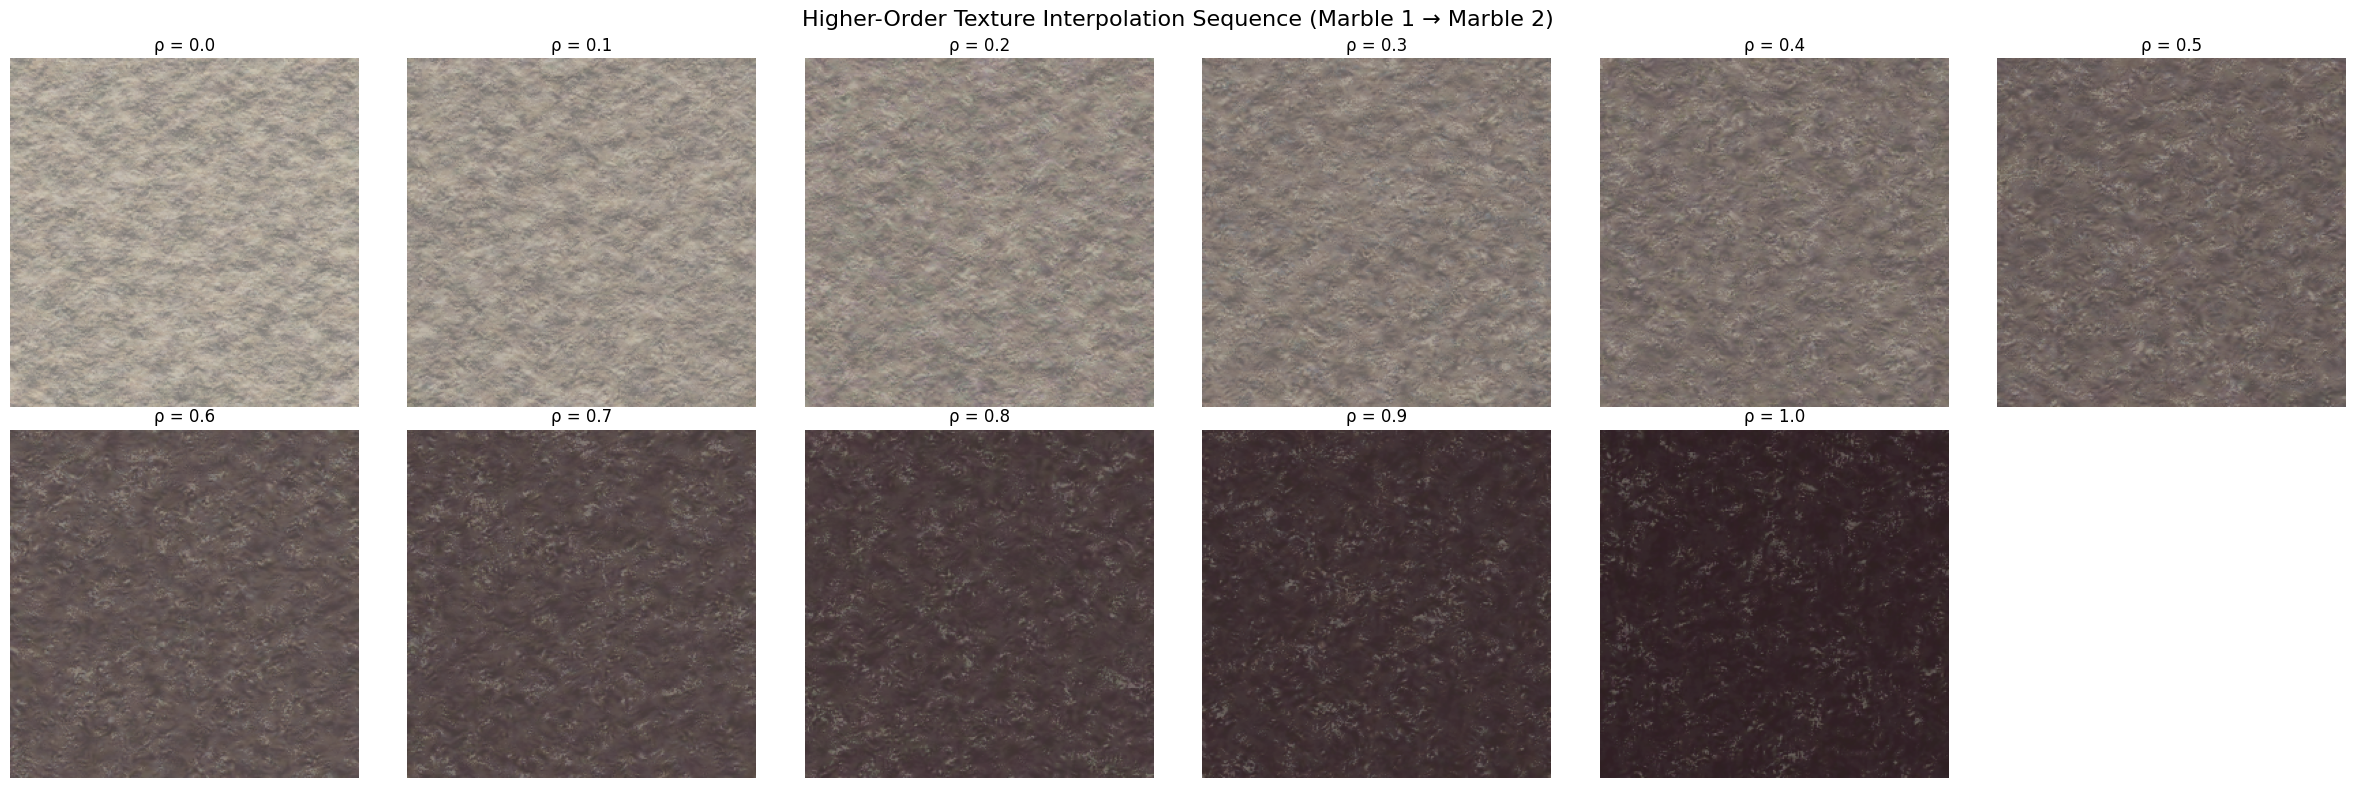

In [25]:
output_dir = "output/higher_order"
os.makedirs(output_dir, exist_ok=True)

# Use marble textures for interpolation
textures = [marble_1_texture, marble_2_texture]

# Save input textures
cv.imwrite(os.path.join(output_dir, "texture_A.png"), cv.cvtColor(marble_1_texture, cv.COLOR_RGB2BGR))
cv.imwrite(os.path.join(output_dir, "texture_B.png"), cv.cvtColor(marble_2_texture, cv.COLOR_RGB2BGR))

# Generate interpolation from 0.0 to 1.0
rhos_list = np.arange(0.0, 1.1, 0.1)

print(f"Generating {len(rhos_list)} interpolated textures with higher-order mixing at 256x256...")
print("="*60)

results = []
for i, rho in enumerate(rhos_list):
    rhos = np.array([rho, 1 - rho])
    
    print(f"\n[{i+1}/{len(rhos_list)}] Synthesizing with rho = {rho:.1f} (weights: [{rho:.1f}, {1-rho:.1f}])")
    
    start = time.time()
    synthesized = higher_order_texture_mixing_gpu(
        textures, rhos,
        height=3,
        order=3,
        n_iter=6,
        K=64,
        step_size=0.1,
        barycenter_iter=100,
        proj_iter=50,
        block_size=4,
        verbose=False
    )
    elapsed = time.time() - start
    
    # Save
    filename = f"synthesized_rho_{rho:.1f}.png"
    cv.imwrite(os.path.join(output_dir, filename), cv.cvtColor(synthesized, cv.COLOR_RGB2BGR))
    
    results.append(synthesized)
    print(f"  Completed in {elapsed:.2f}s - Saved as {filename}")

print(f"\n{'='*60}")
print(f"All textures saved to: {output_dir}")
print(f"{'='*60}")

# Display all results
fig, axes = plt.subplots(2, 6, figsize=(24, 8))
axes = axes.flatten()

for i, (rho, result) in enumerate(zip(rhos_list, results)):
    axes[i].imshow(result)
    axes[i].set_title(f"ρ = {rho:.1f}", fontsize=12)
    axes[i].axis('off')

# Hide extra subplots if any
for i in range(len(rhos_list), len(axes)):
    axes[i].axis('off')

plt.suptitle("Higher-Order Texture Interpolation Sequence (Marble 1 → Marble 2)", fontsize=16, y=0.98)
plt.tight_layout()
plt.show()